In [417]:
import pandas as pd
import numpy as np
import nltk
from cogroo4py.cogroo import Cogroo
import statsmodels.api as sm
# nltk.download('punkt')
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
import language_tool_python as lt
import uol_redacoes_xml as uol
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

pd.set_option('max_colwidth', 1000)

In [578]:
tool = lt.LanguageTool('pt-BR')
cogroo = Cogroo()
# essays = uol.load()

In [220]:
essays_df = pd.read_csv('../data/essays.csv', sep='|')
tool_df = pd.read_csv('../data/correction_language_tool.csv', sep='|')

In [288]:
cogroo_df = pd.read_csv('../data/correction_cogroo.csv', sep='|')

In [77]:
essays_info = essays_df.loc[:, ['essay', 'comp1', 'url']]
essays_info.head()

,essay,comp1,url
0,0,1.0,https://educacao.uol.com.br/bancoderedacoes/redacoes/conflito-entre-liberdade-de-expressao-e-intimidade-bom-senso-e-necessario.htm
1,1,1.0,https://educacao.uol.com.br/bancoderedacoes/redacoes/entre-direitos-individuais-e-escandalos-politicos.htm
2,2,0.5,https://educacao.uol.com.br/bancoderedacoes/redacoes/o-freio-na-liberdade-para-uma-maior-liberdade.htm
3,3,1.0,https://educacao.uol.com.br/bancoderedacoes/redacoes/privilegio-a-informacao.htm
4,4,1.0,https://educacao.uol.com.br/bancoderedacoes/redacoes/limites-entre-direitos.htm


In [78]:
errors_df = tool_df.drop_duplicates(subset=['error'])
errors_df = errors_df.merge(essays_info, on='essay')

## Analysing Language Tool Outputs

### Cleaning Up error Cogroo

In [299]:
cogroo_df = cogroo_df[~cogroo_df['error'].str.contains('space')]

### Cleaning Up errors Tool Language


In [204]:
errors_df['category'].value_counts()

category
CONFUSED_WORDS         104
GRAMMAR                 72
MISC                    54
REDUNDANCY              31
CLICHES                 21
REDACTION_TIPS          21
TYPOGRAPHY              16
PUNCTUATION             12
MISSPELLING             12
FORMAL_SPEECH           12
STYLE                   10
CASING                   7
EGGCORNS                 7
SYNTAX                   6
SEMANTICS                4
COMPOUNDING              3
REPETITIONS              3
CONTRACTIONS             2
REPETITIONS_STYLE        1
WIKIPEDIA                1
TYPOS                    1
FORMAL_SPEECH_PT_BR      1
TRANSLATION_ERRORS       1
Name: count, dtype: int64

#### Generate Examples

In [508]:
for cat in errors_df['category'].unique():
    errors_df[errors_df['category'] == cat].to_csv(f'./examples_before/{cat.lower()}_examples.csv', index=False)

In [511]:
wikipedia_messages = pd.DataFrame(tool_df[tool_df['category'] == 'WIKIPEDIA']['message'].unique(), columns=['message'])
wikipedia_messages.to_csv('./examples_before/wikipedia_messages.txt', index=False)

In [512]:
tool_df[tool_df['category'] == 'SEMANTICS'].to_csv('./examples_before/semantics_all_examples.csv', index=False)

#### Clean dataframe

- Move simplificações and 'prolixa' to Redaction TIPS
- TYPOGRAPHY: Remove
- SEMANTICS: Consider only message "Considere “infringir”, i.e. transgredir, em vez de ‘infligir’, i.e. aplicar" and move to CONFUSED WORDS
- SEMANTICS: When "vc" appears and "ROMAN_NUMBERS_CHECKER" move to category MISSPELLING and error INTERNET_ABBREVIATIONS
- EGGCORNS: Move to Tips
- REPETITIONS: union with REPETITIONS_STYLE
- FORMAL_SPEECH_PT_BR: Remove
- TRANSLATION_ERRORS: Remove
- WIKIPEDIA: Move samples with 'boas-vindas' error to category COMPOUNDING with rule 	PT_COMPOUNDS_POST_REFORM and move rest to grammar except messages with 'seculo'
- STYLE: Move PT_CLICHE_REPLACE to CLICHES and move PORTUGUESE_WORD_REPEAT_BEGINNING_RULE to REPETITIONS
- PONCTUATION: Remove INTERJECTIONS_PUNTUATION

In [582]:
def clean_dataframe(tool_df):
    tool_df_clean = tool_df.copy()

    # Remove FORMAL_SPEECH_PT_BR,  TRANSLATION_ERRORS, TYPOGRAPHY
    tool_df_clean = tool_df_clean[~tool_df_clean['category'].isin(['TYPOGRAPHY', 'TRANSLATION_ERRORS', 'FORMAL_SPEECH_PT_BR'])]
    
    # Move Simplification
    tool_df_clean.loc[tool_df_clean['message'].str.contains('simpli'), 'category'] = 'REDACTION_TIPS'
    tool_df_clean.loc[tool_df_clean['message'].str.contains('prolixa'), 'category'] = 'REDACTION_TIPS'
    
    
    # Clean SEMANTICS
    tool_df_clean.loc[tool_df_clean['message'].str.contains('infringir'), 'category'] = 'CONFUSED_WORDS'
    tool_df_clean.loc[
        (tool_df_clean['message'].str.contains('infringir')) & (tool_df_clean['category'] == 'SEMANTICS')
    , ['error', 'category']] = ['INTERNET_ABBREVIATIONS', 'MISSPELLING']
    tool_df_clean = tool_df_clean[tool_df_clean['category'] != 'SEMANTICS']
    
    # Aggregate EGGCORNS and REDACTION_TIPS
    tool_df_clean.loc[tool_df_clean['category'] == 'EGGCORNS', 'category'] = 'REDACTION_TIPS'
    
    # Aggregate Repetitions
    tool_df_clean.loc[tool_df_clean['category'] == 'REPETITIONS_STYLE', 'category'] = 'REPETITIONS'
    
    # Clean Wikipedia
    
    tool_df_clean.loc[
        (tool_df_clean['message'].str.contains('boas vindas')) & (tool_df_clean['category'] == 'WIKIPEDIA')
    , ['error', 'category']] = ['PT_COMPOUNDS_POST_REFORM', 'COMPOUNDING']
    tool_df_clean.loc[~(tool_df_clean['message'].str.contains('século')) & (tool_df_clean['category'] == 'WIKIPEDIA'), 'category'] = 'GRAMMAR'
    tool_df_clean = tool_df_clean[tool_df_clean['category'] != 'WIKIPEDIA']
    
    # Move Style errors
    tool_df_clean.loc[
        (tool_df_clean['category'] == 'STYLE') &
        (tool_df_clean['error'] == 'PORTUGUESE_WORD_REPEAT_BEGINNING_RULE')
    ,'category'] = 'REPETITIONS'
    
    tool_df_clean.loc[
        (tool_df_clean['category'] == 'STYLE') &
        (tool_df_clean['error'] == 'PORTUGUESE_WORD_REPEAT_BEGINNING_RULE')
    ,'category'] = 'REPETITIONS'
    
    # Remove INTERJECTIONS_PUNTUATION errors
    tool_df_clean.loc[
        (tool_df_clean['category'] == 'STYLE') &
        (tool_df_clean['error'] == 'PT_CLICHE_REPLACE')
    ,'category'] = 'CLICHES'
    
    tool_df_clean = tool_df_clean.loc[~((tool_df_clean['category'] == 'PUNCTUATION') & (tool_df_clean['error'] == 'INTERJECTIONS_PUNTUATION'))]
    
    return tool_df_clean

In [583]:
tool_df_clean = clean_dataframe(tool_df)

In [584]:
error_df_cleaned = tool_df_clean.drop_duplicates(subset=['error'])
for cat in error_df_cleaned['category'].unique():
    error_df_cleaned[error_df_cleaned['category'] == cat].to_csv(f'./examples_after/{cat.lower()}_examples.csv', index=False)

### Analyse Overall Results

#### Comparing Cogroo with tool languagem
<hr/>

In [553]:
cogroo_df.shape[0] + tool_df_clean[tool_df_clean['category'] == 'TYPOS'].shape[0], tool_df_clean.shape[0]

(5710, 14903)

#### Analysing Cleaning
<hr/>

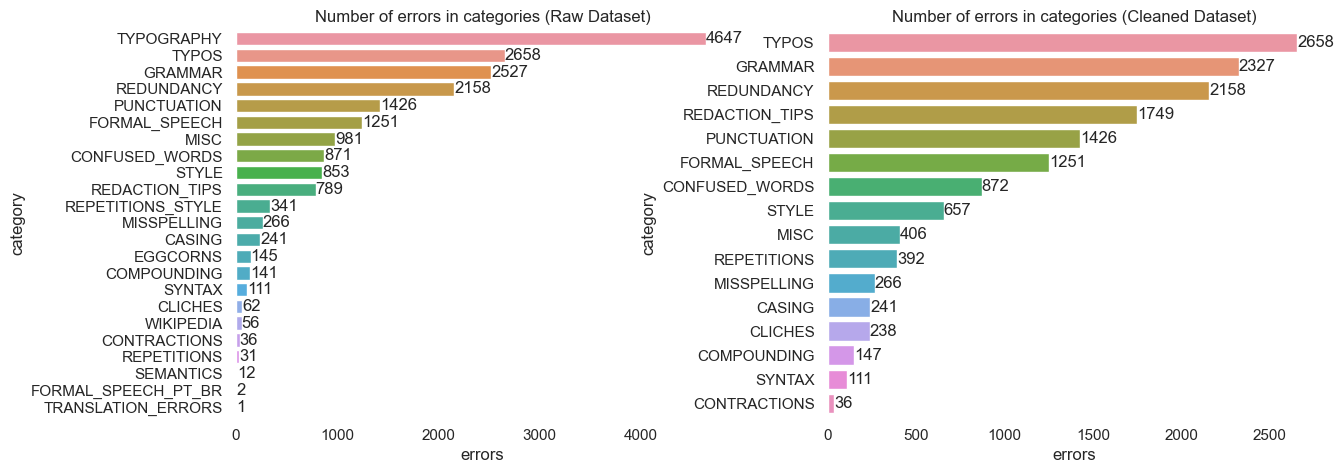

In [490]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
tool_values = tool_df['category'].value_counts()       
axes[0] = sns.barplot(x=tool_values.values, y= tool_values.index, order=tool_values.index, ax=axes[0]) 
axes[0].set(xlabel='errors', title='Number of errors in categories (Raw Dataset)', frame_on=False) 
axes[0].bar_label(axes[0].containers[0])

tool_values_cl = tool_df_clean['category'].value_counts()       
sns.barplot(x=tool_values_cl.values, y= tool_values_cl.index, order=tool_values_cl.index, ax=axes[1]) 
axes[1].set(xlabel='errors', title='Number of errors in categories (Cleaned Dataset)', frame_on=False) 
axes[1].bar_label(axes[1].containers[0]);  

In [554]:
most_comum_errors = tool_df_clean.groupby(by=['error', 'category']).size()
most_comum_errors = most_comum_errors.reset_index(level=[0, 1]).rename(columns={0:'count_errors'})
most_comum_errors = most_comum_errors.sort_values(by='count_errors', ascending=False).head(10)

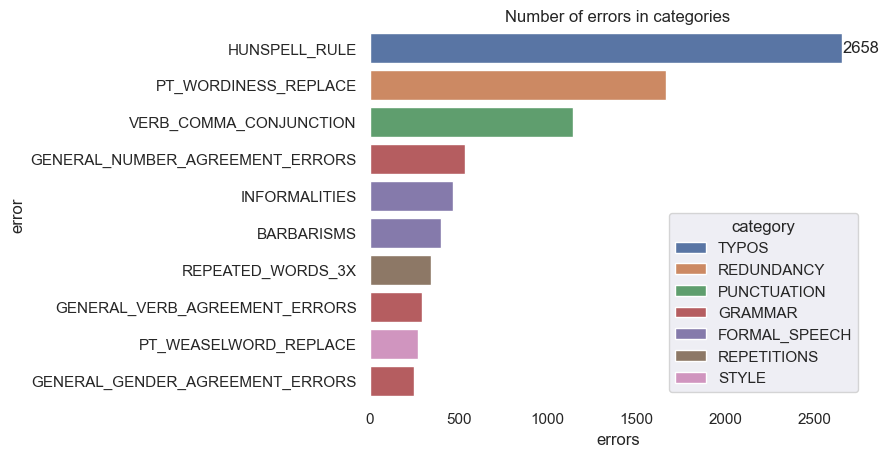

In [572]:
values = tool_df_clean['error'].value_counts().head(10)      # compute counts by class
ax = sns.barplot(x=most_comum_errors['count_errors'], y= most_comum_errors['error'], hue=most_comum_errors['category'], dodge=False) # plot count plot
ax.set(xlabel='errors', title='Number of errors in categories', frame_on=False) # prettify
# ax.tick_params(length=0)                               # remove tick liens
ax.bar_label(ax.containers[0]);     

### Generate and Analyse language tool features

In [560]:
features_df = tool_df_clean.groupby(['essay', 'category']).size().unstack(fill_value=0)
features_df

category,CASING,CLICHES,COMPOUNDING,CONFUSED_WORDS,CONTRACTIONS,FORMAL_SPEECH,GRAMMAR,MISC,MISSPELLING,PUNCTUATION,REDACTION_TIPS,REDUNDANCY,REPETITIONS,STYLE,SYNTAX,TYPOS
essay,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1
1,1,0,0,1,0,1,1,0,0,0,2,1,0,2,0,1
2,0,0,0,0,1,1,2,0,0,1,2,2,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0
4,0,0,0,3,0,1,1,0,0,1,2,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159,0,0,1,0,0,7,2,0,1,0,1,2,0,1,0,1
2160,0,0,0,0,0,6,2,1,0,0,1,0,0,0,0,4
2161,0,0,0,0,0,3,2,0,0,0,2,1,0,1,0,3


In [561]:
features_df[features_df.drop(columns='REDACTION_TIPS').apply(sum, axis=1) == 0].shape

(19, 16)

In [562]:
features_df[features_df.apply(sum, axis=1) == 0].shape

(0, 16)

In [563]:
features_df.describe().iloc[1:, ]

category,CASING,CLICHES,COMPOUNDING,CONFUSED_WORDS,CONTRACTIONS,FORMAL_SPEECH,GRAMMAR,MISC,MISSPELLING,PUNCTUATION,REDACTION_TIPS,REDUNDANCY,REPETITIONS,STYLE,SYNTAX,TYPOS
mean,0.112512,0.111111,0.068627,0.407096,0.016807,0.584034,1.086368,0.189542,0.124183,0.650794,0.816527,1.007470,0.183007,0.306723,0.051821,1.240896
std,0.434331,0.344135,0.287455,0.895005,0.128577,1.023857,1.315133,0.495211,0.432759,0.917624,0.987757,1.117539,0.575160,0.672223,0.241867,2.257966
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000
max,5.000000,3.000000,3.000000,8.000000,1.000000,9.000000,10.000000,5.000000,4.000000,6.000000,6.000000,10.000000,7.000000,7.000000,3.000000,28.000000


In [564]:
num_err = tool_df_clean.groupby('essay').size().reset_index().rename(columns={0:'errors'})
num_err = num_err.merge(essays_df.loc[:,['essay', 'comp1']], on='essay')
num_err['comp1'] = num_err['comp1'].astype(str)

[Text(0.5, 0, 'Grade Competence 1 '),
 Text(0.5, 1.0, 'Relationship between number of detected errors and the grades')]

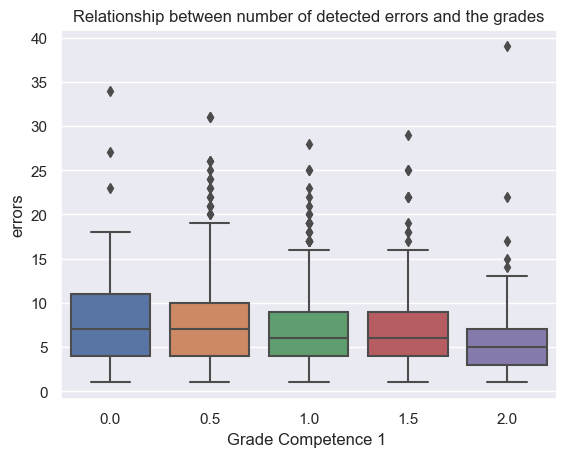

In [565]:
ax = sns.boxplot(data=num_err, x='comp1', y='errors', order=['0.0','0.5', '1.0', '1.5', '2.0'])
ax.set(xlabel='Grade Competence 1 ', title='Relationship between number of detected errors and the grades') 